Found 126 figure files
 - gan_epoch001_samples.png
 - gan_epoch002_samples.png
 - gan_epoch003_samples.png
 - gan_epoch004_samples.png
 - gan_epoch005_samples.png
 - gan_epoch006_samples.png
 - gan_epoch007_samples.png
 - gan_epoch008_samples.png
 - gan_epoch009_samples.png
 - gan_epoch010_samples.png


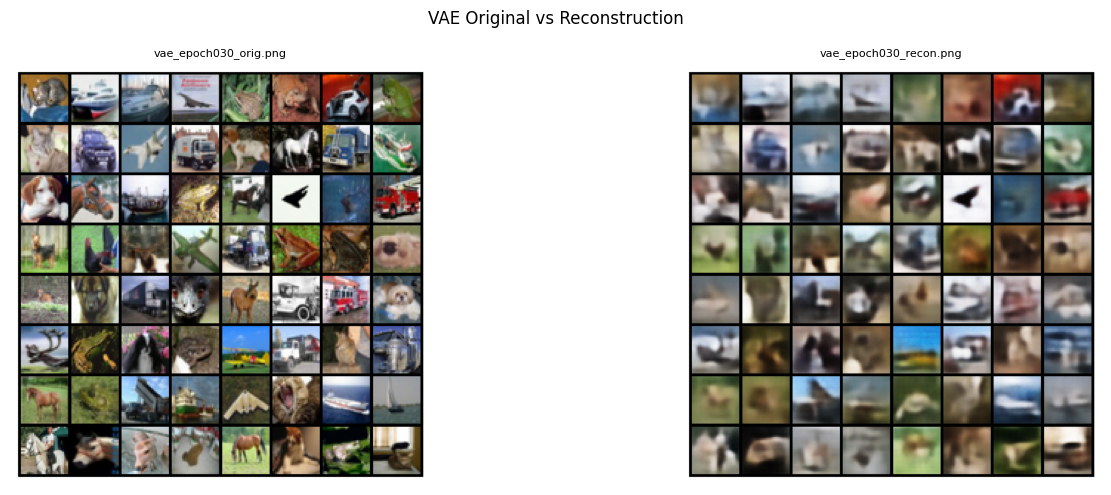

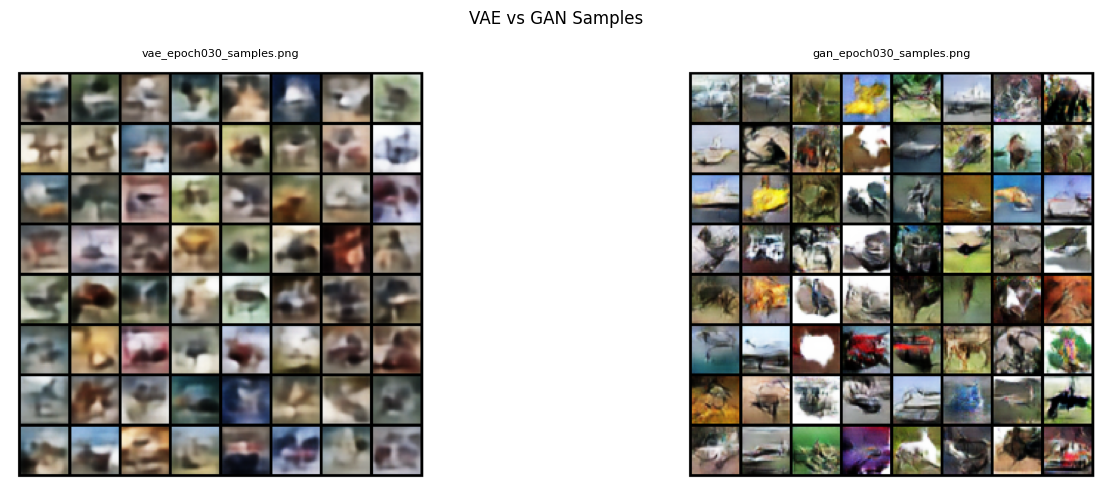

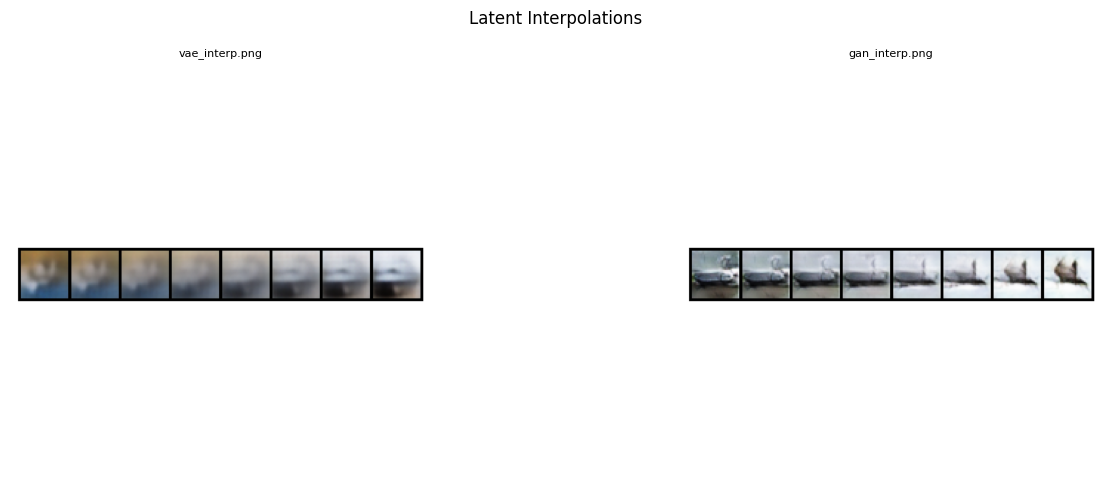

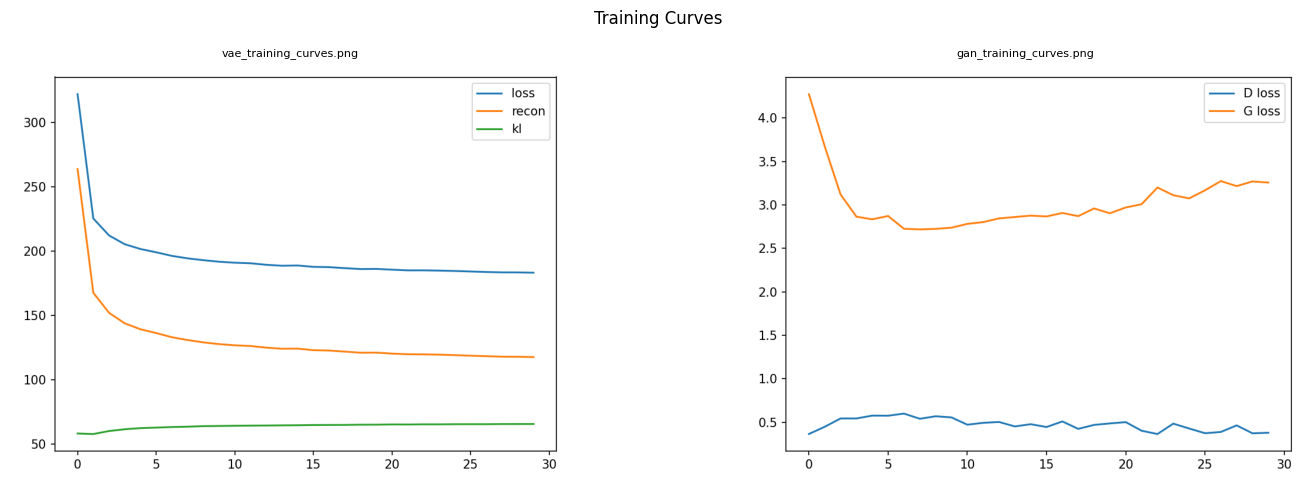

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

run_dir = Path("/Users/basil/Downloads/content/runs/20250921_130015") / "figures"

images = sorted([f for f in run_dir.glob("*.png")])
print(f"Found {len(images)} figure files")
for img in images[:10]:
    print(" -", img.name)

def show_images(img_paths, ncols=3, figsize=(15,5), title=None):
    n = len(img_paths)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, path in enumerate(img_paths):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(path.name, fontsize=8)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    if title: 
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

vae_orig = run_dir / "vae_epoch030_orig.png"
vae_recon = run_dir / "vae_epoch030_recon.png"
show_images([vae_orig, vae_recon], ncols=2, title="VAE Original vs Reconstruction")

vae_sample = run_dir / "vae_epoch030_samples.png"
gan_sample = run_dir / "gan_epoch030_samples.png"
show_images([vae_sample, gan_sample], ncols=2, title="VAE vs GAN Samples")

vae_interp = run_dir / "vae_interp.png"
gan_interp = run_dir / "gan_interp.png"
show_images([vae_interp, gan_interp], ncols=2, title="Latent Interpolations")

show_images([run_dir / "vae_training_curves.png", run_dir / "gan_training_curves.png"], ncols=2, title="Training Curves")




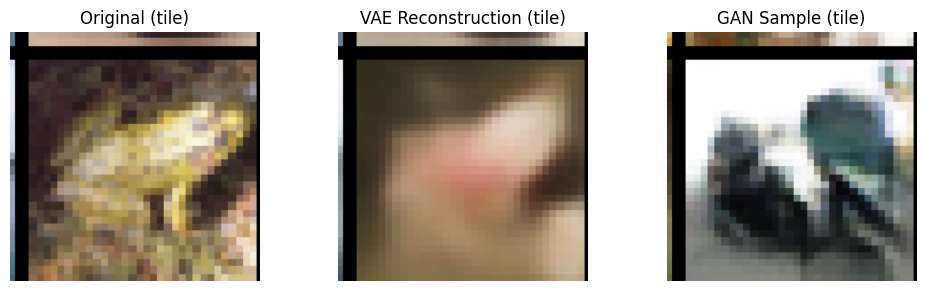

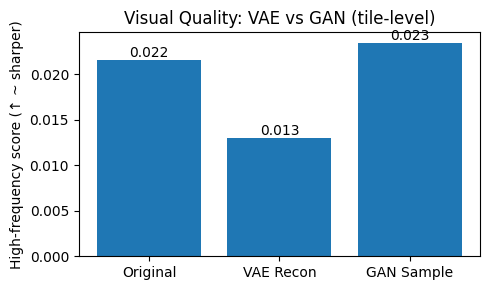

Files used:
 - vae_epoch030_orig.png
 - vae_epoch030_recon.png
 - gan_epoch030_samples.png
Tile location: row=2, col=3


In [ ]:
import os
from pathlib import Path
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

RUN_DIR = Path("/Users/basil/Downloads/content/runs/20250921_130015/figures")
ROW, COL = 2, 3          
N_COLS = 8                
PAD = 2                   

def latest_epoch_file(prefix, suffix=".png"):
    pattern = re.compile(rf"{re.escape(prefix)}(\d+){re.escape(suffix)}")
    candidates = []
    for p in RUN_DIR.glob(f"{prefix}*{suffix}"):
        m = pattern.match(p.name)
        if m:
            candidates.append((int(m.group(1)), p))
    if not candidates:
        return None
    return sorted(candidates, key=lambda x: x[0])[-1][1]

vae_orig = latest_epoch_file("vae_epoch", "_orig.png")
vae_recon = latest_epoch_file("vae_epoch", "_recon.png")
gan_sample = latest_epoch_file("gan_epoch", "_samples.png")

if not (vae_orig and vae_recon and gan_sample):
    raise FileNotFoundError("Could not find required figure files in RUN_DIR. "
                            f"Found: vae_orig={vae_orig}, vae_recon={vae_recon}, gan_sample={gan_sample}")

def crop_grid_tile(img_path, row, col, ncols=N_COLS, pad=PAD):
    """Crop (row, col) tile from a vutils.make_grid image (assuming uniform tiles)."""
    im = Image.open(img_path).convert("RGB")
    W, H = im.size
    tile_w = (W - pad*(ncols-1)) // ncols
    tile_h = tile_w  
    nrows = (H + pad) // (tile_h + pad)  
    x0 = col * (tile_w + pad)
    y0 = row * (tile_h + pad)
    x0 = min(max(0, x0), W - tile_w)
    y0 = min(max(0, y0), H - tile_h)
    crop = im.crop((x0, y0, x0 + tile_w, y0 + tile_h))
    return crop

tile_orig  = crop_grid_tile(vae_orig, ROW, COL)
tile_recon = crop_grid_tile(vae_recon, ROW, COL)
tile_gan   = crop_grid_tile(gan_sample, ROW, COL)

def hf_score(pil_img):
    """Simple high-frequency score using gradient magnitude; higher ~ sharper."""
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    gray = 0.2989*arr[...,0] + 0.5870*arr[...,1] + 0.1140*arr[...,2]
    gx = np.abs(np.diff(gray, axis=1))
    gy = np.abs(np.diff(gray, axis=0))
    return float((gx.mean() + gy.mean()) / 2.0)

scores = {
    "Original": hf_score(tile_orig),
    "VAE Recon": hf_score(tile_recon),
    "GAN Sample": hf_score(tile_gan),
}

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(tile_orig);  axes[0].set_title("Original (tile)")
axes[1].imshow(tile_recon); axes[1].set_title("VAE Reconstruction (tile)")
axes[2].imshow(tile_gan);   axes[2].set_title("GAN Sample (tile)")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
labels = list(scores.keys())
vals = [scores[k] for k in labels]
plt.bar(labels, vals)
plt.ylabel("High-frequency score (↑ ~ sharper)")
plt.title("Visual Quality: VAE vs GAN (tile-level)")
for i, v in enumerate(vals):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()
print("Files used:")
print(" -", vae_orig.name)
print(" -", vae_recon.name)
print(" -", gan_sample.name)
print(f"Tile location: row={ROW}, col={COL}")
